# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [9]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [10]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/02_activities/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [11]:
import requests

# Function to download a file from a URL
def download_file(url, file_path):
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

# Correct URL for downloading the dataset
dataset = 'shakespeare.txt'
url = 'https://github.com/UofT-DSI/deep_learning/raw/main/02_activities/assignments/downloaded_books/' + dataset

# Download the dataset
download_file(url, dataset)

# Load and check the dataset
def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

text = load_dataset(dataset, fraction=0.1)

# Print the first 1000 characters of the dataset
print("First 1000 characters of the dataset:\n")
print(text[:1000])

# Report the dataset's size
dataset_size = len(text)
print("\nSize of the dataset (number of characters):")
print(dataset_size)

# Report the number of unique characters in the dataset
unique_characters = set(text)
num_unique_characters = len(unique_characters)
print("\nNumber of unique characters in the dataset:")
print(num_unique_characters)


First 1000 characters of the dataset:

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For thi

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [4]:
#####REMOVE
from keras.preprocessing.text import Tokenizer

# Your code here
VOCAB_SIZE = None
OOV_TOKEN = None

tokenizer = None

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Convert text to lowercase
text = text.lower()

# Define vocabulary size and out-of-vocabulary token
VOCAB_SIZE = 10000  # You can adjust this based on your data and requirements
OOV_TOKEN = "<OOV>"

# Initialize the Tokenizer with specified vocabulary size and out-of-vocabulary token
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])

# Convert the text to a sequence of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Print the first 10 words in the vocabulary
print("First 10 words in the vocabulary:")
print(list(tokenizer.word_index.items())[:10])


First 10 words in the vocabulary:
[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [13]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [6]:
SEQ_LENGTH = None # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = None

# Generate the training sequences
X = []
y = []
# Your code here

In [20]:
import numpy as np
from keras.preprocessing.text import Tokenizer

# Set SEQ_LENGTH
SEQ_LENGTH = 50  # Choose an appropriate sequence length

# Assuming `text` and `tokenizer` have been defined previously
# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []
for i in range(len(sequences) - SEQ_LENGTH):
    X.append(sequences[i:i + SEQ_LENGTH])
    y.append(sequences[i + SEQ_LENGTH])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Print the first training sequence and its target
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2  216    4
    2   56   54  297 1248   14   20  411]
Target: 29
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook'] -> or


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [21]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2  216    4
    2   56   54  297 1248   14   20  411]
Target: 29
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook'] -> or


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [22]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (122721, 50)
y_train shape: (122721, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    # Your code here
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

No layers have been added to the model. Please complete the assignment by adding the required layers.


In [24]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define the model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=SEQ_LENGTH),
    LSTM(128, return_sequences=True),  # First LSTM layer
    LSTM(128),                        # Second LSTM layer
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer with softmax
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 10000)             1290000   
                                                                 
Total params: 2,538,832
Trainable params: 2,538,832
Non-trainable params: 0
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [25]:
# Your code here
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Explanation:
# - 'categorical_crossentropy' is used because the problem is a multi-class classification problem.
# - 'adam' is chosen because it is a popular optimizer that adapts the learning rate and works well in practice.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

Epoch 1/5
959/959 [==============================] - 130s 133ms/step - loss: 7.0582 - accuracy: 0.0465 - val_loss: 6.8323 - val_accuracy: 0.0532
Epoch 2/5
959/959 [==============================] - 141s 147ms/step - loss: 6.6367 - accuracy: 0.0621 - val_loss: 6.7912 - val_accuracy: 0.0573
Epoch 3/5
959/959 [==============================] - 167s 174ms/step - loss: 6.3749 - accuracy: 0.0810 - val_loss: 6.4174 - val_accuracy: 0.0850
Epoch 4/5
959/959 [==============================] - 176s 183ms/step - loss: 6.0359 - accuracy: 0.0997 - val_loss: 6.2536 - val_accuracy: 0.1007
Epoch 5/5
959/959 [==============================] - 173s 180ms/step - loss: 5.7666 - accuracy: 0.1137 - val_loss: 6.1250 - val_accuracy: 0.1090


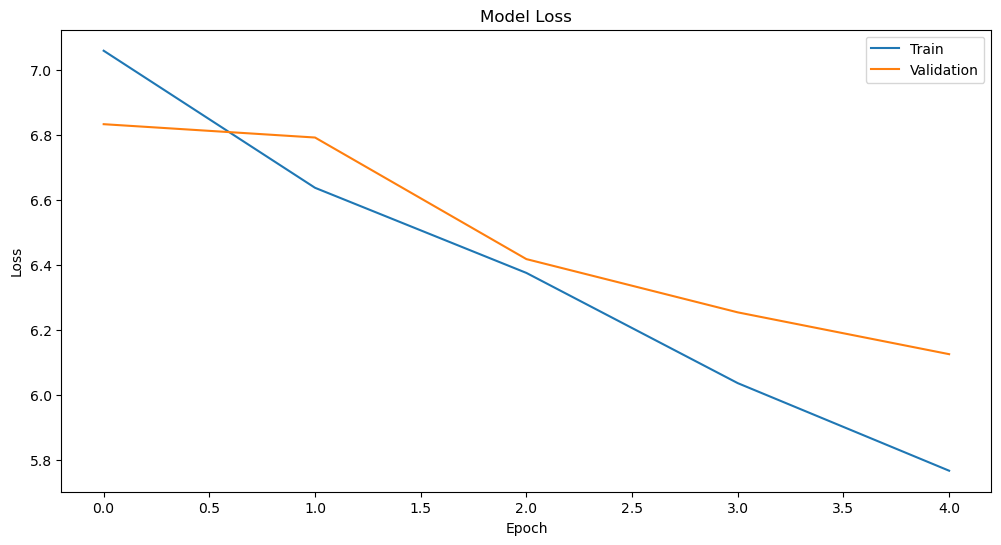

In [26]:
# Your code here
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

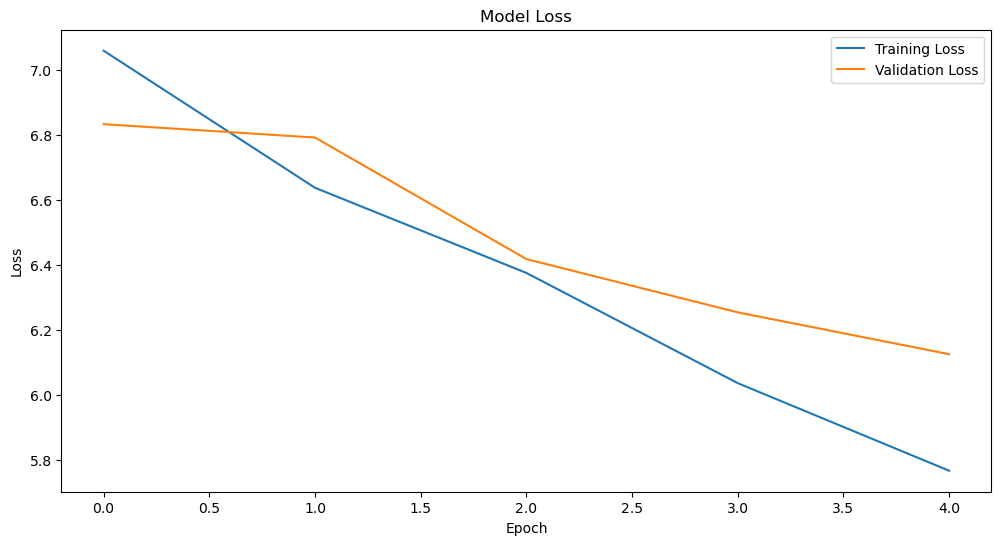

In [27]:
import matplotlib.pyplot as plt

# Your code here
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Display the plot
plt.show()


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model using the provided sequence.
    Introduces randomness to make the text generation more interesting.
    """
    yhat = model.predict(sequence, verbose=0)
    
    
    temperature = 1.0
    yhat = np.log(yhat + 1e-7) / temperature
    yhat = np.exp(yhat)
    yhat = yhat / np.sum(yhat)  
    
    
    return np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.
    """
    # Tokenize and pad the seed text
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    tokenized_text = pad_sequences([tokenized_text], maxlen=max_sequence_len, padding='pre')
    
    generated_text = seed_text

    for _ in range(num_words):
        # Predict the next word
        predicted_word_index = get_predicted_word(model, tokenized_text)
        
        # Convert the predicted word index back to a word
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        if predicted_word == '':
            break  # Stop if the predicted word is out-of-vocabulary
        
        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word
        
        # Update the tokenized_text for the next prediction
        tokenized_text = np.roll(tokenized_text, shift=-1)
        tokenized_text[0, -1] = predicted_word_index
    
    return generated_text

# Test the text generation function
generated_text = generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH, num_words=50)
print(generated_text)


hamlet of george and hence moves shakespeare than you see a first om trophies of the whips of nature the instance five f1 to comedies special raven further printed and retiring to my card julius my writing your prevision capulets this alteration indirect story of fault’s the terms of stratford or


In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    
    return None


In [14]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [53]:
import requests
import zipfile
import os

# URL for the GloVe embeddings
url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
zip_path = 'glove.6B.zip'
extract_dir = 'glove.6B/'

# Download the file
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extract the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Extracted files to {extract_dir}')


Extracted files to glove.6B/


In [55]:
import numpy as np

def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = os.path.join(extract_dir, 'glove.6B.100d.txt') 
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_file_path, embedding_dim)

# Check a few embeddings
print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [56]:
from keras.preprocessing.text import tokenizer_from_json
import numpy as np

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    num_words = len(tokenizer.word_index) + 1  
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in tokenizer.word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, embedding_dim)

print(f"Embedding matrix shape: {embedding_matrix.shape}")


Embedding matrix shape: (10, 100)


In [ ]:
import numpy as np
import os
import zipfile
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy

url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
zip_path = 'glove.6B.zip'
extract_dir = 'glove.6B/'

response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = os.path.join(extract_dir, 'glove.6B.100d.txt')
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_file_path, embedding_dim)

# Tokenize text and create embedding matrix
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=SEQ_LENGTH)

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    num_words = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, embedding_dim)
VOCAB_SIZE = len(tokenizer.word_index) + 1

# Define and compile the model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=SEQ_LENGTH, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Prepare data for training
y_train = np.array(y_train)  
y_val = np.array(y_val)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val)
)


# Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.